# 1. ResNet残差网络

非常深的神经网络是很难训练的，因为存在梯度消失和梯度爆炸问题

可以利用跳跃连接构建能够训练深度网络的ResNets

和利用dropout 正则化防止过拟合

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np

# 载入数据集
mnist = input_data.read_data_sets("../data/", one_hot=True)

# 显示数据集数量
print("训练集数量：", mnist.train.num_examples)
print("验证集数量：", mnist.validation.num_examples)
print("测试集数量：", mnist.test.num_examples)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
训练集数量： 55000
验证集数量： 5000
测试集数量： 10000


# 2. 数据读取

利用网上的 MNIST 数据集(http://yann.lecun.com/exdb/mnist/)获取数据集压缩文件（切勿解压）：

train-images-idx3-ubyte.gz --- 6万张28x28大小的训练数字图像

train-labels-idx1-ubyte.gz --- 6万张训练图像的数字标记

t10k-images-idx3-ubyte.gz  --- 1万张28x28大小的测试数字图像

t10k-labels-idx1-ubyte.gz  --- 1万张测试图像的数字标记

In [2]:
# 显示数据集大小
print("训练图像大小：", mnist.train.images.shape)
print("训练标签大小：", mnist.train.labels.shape)

训练图像大小： (55000, 784)
训练标签大小： (55000, 10)


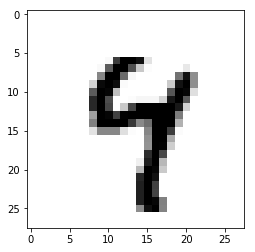

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [3]:
# 可视化图像
def plot_image(image):
    plt.imshow(image.reshape(28, 28), cmap='binary')
    plt.show()


# 可视化第二张训练图像
plot_image(mnist.train.images[2])

# 可视化第二张图像的标签
print(mnist.train.labels[2])

# 3. 构建模型

In [4]:
# 定义训练数据的占位符， x是784个像素点的特征值， y是10分类的标签值
x = tf.placeholder(tf.float32, [None, 784], name="X")
y = tf.placeholder(tf.float32, [None, 10], name="Y")

# 为了使用卷积层，需把x变成一个4d向量，其第2、第3维对应图片的宽、高，最后一维代表图片的颜色通道数
x_image = tf.reshape(x, [-1, 28, 28, 1])


# 权重W 初始化 从标准差0.1的截断正态分布中输出随机值
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


# 权重b 初始化 0.1
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


# 定义1步长的 same卷积
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


# 定义步长为2 大小2x2的 max pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def res_block(x, kernal_size_x, kernal_size_y, channel_in, channel_out):
    X_shortcut = x
    channel_out_half = int(channel_out / 2)
    # 第一卷积层
    with tf.variable_scope("res_conv1"):
        res_w_conv1 = weight_variable([kernal_size_x, kernal_size_y, channel_in, channel_out_half])
        res_b_conv1 = bias_variable([channel_out_half])
        res_h_conv1 = tf.nn.relu(conv2d(x, res_w_conv1) + res_b_conv1)
    # 第二卷积层
    with tf.variable_scope("res_conv2"):
        res_w_conv2 = weight_variable([kernal_size_x, kernal_size_y, channel_out_half, channel_out])
        res_b_conv2 = bias_variable([channel_out])
        res_h_conv2 = tf.nn.relu(conv2d(res_h_conv1, res_w_conv2) + res_b_conv2)
    # 残差块
    with tf.variable_scope("shortcut"):
        # 输入层在线性激活之后，维持通道数与第二卷积层相同
        res_w_shortcut = weight_variable([1, 1, channel_in, channel_out])
        res_b_shortcut = bias_variable([channel_out])
        X_shortcut = conv2d(X_shortcut, res_w_shortcut) + res_b_shortcut
        # 在ReLU激活之前，与第二卷积层相加，产生了一个残差块
        res_add = tf.add(res_h_conv2, X_shortcut)
        res_b_shortcut = bias_variable([channel_out])
        res_add_result = tf.nn.relu(res_add + res_b_shortcut)

    return res_add_result


# 第一个残差块
h_res1 = res_block(x_image, 3, 3, 1, 32)
# 第一层池化
h_pool1 = max_pool_2x2(h_res1)
# 进行局部响应归一化操作
h1 = tf.nn.lrn(h_pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)

# 第二个残差块
h_res2 = res_block(h1, 5, 5, 32, 64)
# 第二层池化
h_pool2 = max_pool_2x2(h_res2)
# 进行局部响应归一化操作
h2 = tf.nn.lrn(h_pool2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
h2_flat = tf.reshape(h2, shape=[-1, 7 * 7 * 64])  # 重新展开

# 第三阶段全连接层1
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h2_flat, W_fc1) + b_fc1)

# 第四阶段dropout层
dropout_rate = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, rate=dropout_rate)

# 第五阶段全连接层2
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
forward = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
pred = tf.nn.softmax(forward)

train_epochs = 20  # 迭代次数
learning_rate = 1e-3  # 学习率

# 定义损失函数
with tf.name_scope("LossFunction"):
    loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=forward, labels=y))

Instructions for updating:
Colocations handled automatically by placer.


# 4. 训练模型

In [5]:
# Adam优化器 设置学习率和优化目标损失最小化
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_function)

# 定义预测类别匹配情况
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

# 定义准确率，将布尔值转化成浮点数，再求平均值
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

sess = tf.Session()  # 建立会话
init = tf.global_variables_initializer()  # 变量初始化
sess.run(init)

# 每个批次的大小，每次放入的大小，每次放入 100张图片 以矩阵的方式
batch_size = 100

# 计算一共有多少个批次，数量整除大小训练出有多少批次
n_batch = mnist.train.num_examples // batch_size

for epoch in range(train_epochs):
    for batch in range(n_batch):
        xs, ys = mnist.train.next_batch(batch_size)
        sess.run(optimizer, feed_dict={x: xs, y: ys, dropout_rate: 0.5})
        # 批次训练完成之后，使用验证数据计算误差与准确率
    loss, acc = sess.run([loss_function, accuracy],
                         feed_dict={x: mnist.validation.images,
                                    y: mnist.validation.labels,
                                    dropout_rate: 0})
    # 显示训练信息
    print("Train Epoch", '%02d' % (epoch + 1), "Loss=", '{:.9f}'.format(loss),
          "Accuracy=", "{:.4f}".format(acc))

Train Epoch 01 Loss= 0.103925243 Accuracy= 0.9712
Train Epoch 02 Loss= 0.068904892 Accuracy= 0.9808
Train Epoch 03 Loss= 0.052916307 Accuracy= 0.9846
Train Epoch 04 Loss= 0.047417201 Accuracy= 0.9878
Train Epoch 05 Loss= 0.045173906 Accuracy= 0.9876
Train Epoch 06 Loss= 0.041291334 Accuracy= 0.9880
Train Epoch 07 Loss= 0.040540095 Accuracy= 0.9882
Train Epoch 08 Loss= 0.044096928 Accuracy= 0.9872
Train Epoch 09 Loss= 0.044790849 Accuracy= 0.9892
Train Epoch 10 Loss= 0.036397565 Accuracy= 0.9898
Train Epoch 11 Loss= 0.043122139 Accuracy= 0.9884
Train Epoch 12 Loss= 0.037767597 Accuracy= 0.9896
Train Epoch 13 Loss= 0.035879690 Accuracy= 0.9890
Train Epoch 14 Loss= 0.028891217 Accuracy= 0.9916
Train Epoch 15 Loss= 0.041857451 Accuracy= 0.9914
Train Epoch 16 Loss= 0.036687627 Accuracy= 0.9908
Train Epoch 17 Loss= 0.031272657 Accuracy= 0.9926
Train Epoch 18 Loss= 0.041658025 Accuracy= 0.9912
Train Epoch 19 Loss= 0.031089630 Accuracy= 0.9920
Train Epoch 20 Loss= 0.033109900 Accuracy= 0.9936


# 5. 评估模型

In [6]:
# 测试集上评估模型预测的准确率
accu_test = sess.run(accuracy, feed_dict={x: mnist.test.images,
                                          y: mnist.test.labels,
                                          dropout_rate: 0})
print("Test Accuracy = ", accu_test)

# 验证集上评估模型预测的准确率
accu_validation = sess.run(accuracy, feed_dict={x: mnist.validation.images,
                                                y: mnist.validation.labels,
                                                dropout_rate: 0})
print("Validation Accuracy = ", accu_validation)

Test Accuracy =  0.9925
Validation Accuracy =  0.9936


# 6. 模型预测

In [7]:
# 转换pred预测结果独热编码格式为数字0-9
prediction_result = sess.run(tf.argmax(pred, 1), feed_dict={x: mnist.test.images, dropout_rate: 0})

# 查看第500-509张测试图片的预测结果
print(prediction_result[500:510])

[3 9 5 2 1 3 1 3 6 5]


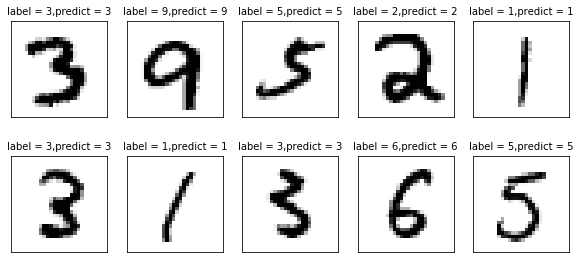

In [8]:
# 定义比对可视化函数
def plot_images_labels_prediction(images,  # 图像列表
                                  labels,  # 标签列表
                                  prediction,  # 预测值列表
                                  index,  # 开始显示的索引
                                  num=5):  # 缺省一次显示5张
    fig = plt.gcf()  # 获取当前图表，get current figure
    fig.set_size_inches(10, 12)  # 1英寸等于2.54cm

    if num > 25:  # 最多显示25张图片
        num = 25

    for i in range(0, num):
        ax = plt.subplot(5, 5, i + 1)  # 获取当前要处理的图片
        ax.imshow(np.reshape(images[index], (28, 28)), cmap='binary')  # 显示第index个图像
        title = 'label = ' + str(np.argmax(labels[index]))  # 显示标签的标题
        if len(prediction) > 0:  # 如果有预测结果的话，添加显示预测的标题
            title += ',predict = ' + str(prediction[index])
        ax.set_title(title, fontsize=10)  # 显示图上的标题
        # 不显示坐标轴
        ax.set_xticks([])
        ax.set_yticks([])
        index += 1
    plt.show()


# 可视化第500-509张测试图片的预测结果对比
plot_images_labels_prediction(mnist.test.images,
                              mnist.test.labels,
                              prediction_result,
                              500, 10)